# Imports & Setup


In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from pathlib import Path

DATA_DIR = Path("/Users/domenicschmidt/Documents/master thesis/lung-cancer-gnn/data/raw")

files = {
    "disease_gene":                    "disease_gene.csv",
    "disease_gene_fusion":             "disease_gene_fusion.csv",
    "disease_chrom_rearr":             "disease_chromosomal_rearrangement.csv",
    "disease_variant":                 "disease_variant.csv",
    "pathway_disease_association":     "pathway_disease_association.csv",
    "disease_gene_pathway":            "disease_gene_pathway.csv",
    "disease_biomarker":               "disease_biomarker.csv",
    "chemical_evidence":               "chemical_evidence.csv",
    "chemical_location":               "chemical_location.csv",
    "disease_demographics":            "disease_demographics.csv",
}

dfs = {name: pd.read_csv(DATA_DIR / fname) for name, fname in files.items()}


/var/folders/lj/bdrxx0g5275bd033dh_9k0h00000gn/T/ipykernel_48930/3926915086.py:22: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = {name: pd.read_csv(DATA_DIR / fname) for name, fname in files.items()}


# Node counts


In [5]:
# %% Node counts
disease_ids = set()
gene_ids = set()
variant_ids = set()
gene_fusion_ids = set()
chrom_rearr_ids = set()
pathway_ids = set()
biomarker_ids = set()
chemical_ids = set()
evidence_ids = set()
city_ids = set()
demo_groups = set()

# Diseases
for name, df in dfs.items():
    if "DiseaseCui" in df.columns:
        disease_ids.update(df["DiseaseCui"].unique())

# Genes
if "disease_gene" in dfs:
    gene_ids.update(dfs["disease_gene"]["GeneId"].dropna().unique())
if "disease_gene_pathway" in dfs:
    gene_ids.update(dfs["disease_gene_pathway"]["GeneId"].dropna().unique())
if "disease_variant" in dfs:
    gene_ids.update(dfs["disease_variant"]["GeneId"].dropna().unique())

# Variants
variant_ids.update(dfs["disease_variant"]["VariantId"].dropna().unique())

# Gene fusions
gene_fusion_ids.update(dfs["disease_gene_fusion"]["GeneFusion"].dropna().unique())

# Chromosomal rearrangements
chrom_rearr_ids.update(dfs["disease_chrom_rearr"]["ChromosomalRearrengementName"].dropna().unique())

# Pathways
pathway_ids.update(dfs["disease_gene_pathway"]["PathwayId"].dropna().unique())
pathway_ids.update(dfs["pathway_disease_association"]["PathwayId"].dropna().unique())

# Biomarkers
biomarker_ids.update(dfs["disease_biomarker"]["BiomarkerId"].dropna().unique())

# Chemicals, Evidence, City
chemical_ids.update(dfs["chemical_evidence"]["ChemicalId"].dropna().unique())
chemical_ids.update(dfs["chemical_location"]["ChemicalId"].dropna().unique())
evidence_ids.update(dfs["chemical_evidence"]["EvidenceId"].dropna().unique())
city_ids.update(dfs["chemical_location"]["CityId"].dropna().unique())

# Demographic groups
demo_groups.update(dfs["disease_demographics"]["DemographicGroup"].dropna().unique())

node_stats = {
    "disease": len(disease_ids),
    "gene": len(gene_ids),
    "variant": len(variant_ids),
    "gene_fusion": len(gene_fusion_ids),
    "chrom_rearr": len(chrom_rearr_ids),
    "pathway": len(pathway_ids),
    "biomarker": len(biomarker_ids),
    "chemical": len(chemical_ids),
    "evidence": len(evidence_ids),
    "city": len(city_ids),
    "demographic_group": len(demo_groups),
}
pd.DataFrame.from_dict(node_stats, orient="index", columns=["num_nodes"])


,num_nodes
disease,58
gene,14779
variant,285747
gene_fusion,4266
chrom_rearr,1993
pathway,1488
biomarker,24
chemical,160
evidence,144
city,368


# Edge counts direkt aus den DataFrames


In [ ]:
edge_stats = {
    "disease_gene":                len(dfs["disease_gene"]),
    "disease_gene_fusion":         len(dfs["disease_gene_fusion"]),
    "disease_chrom_rearr":         len(dfs["disease_chrom_rearr"]),
    "disease_variant":             len(dfs["disease_variant"]),
    "pathway_disease_association": len(dfs["pathway_disease_association"]),
    "disease_gene_pathway":        len(dfs["disease_gene_pathway"]),
    "disease_biomarker":           len(dfs["disease_biomarker"]),
    "chemical_evidence":           len(dfs["chemical_evidence"]),
    "chemical_location":           len(dfs["chemical_location"]),
    "disease_demographics":        len(dfs["disease_demographics"]),
}
pd.DataFrame.from_dict(edge_stats, orient="index", columns=["num_edges"])


,num_edges
disease_gene,82461
disease_gene_fusion,4289
disease_chrom_rearr,2309
disease_variant,500000
pathway_disease_association,168
disease_gene_pathway,50651
disease_biomarker,24
chemical_evidence,198
chemical_location,373
disease_demographics,204


# Schema Graph


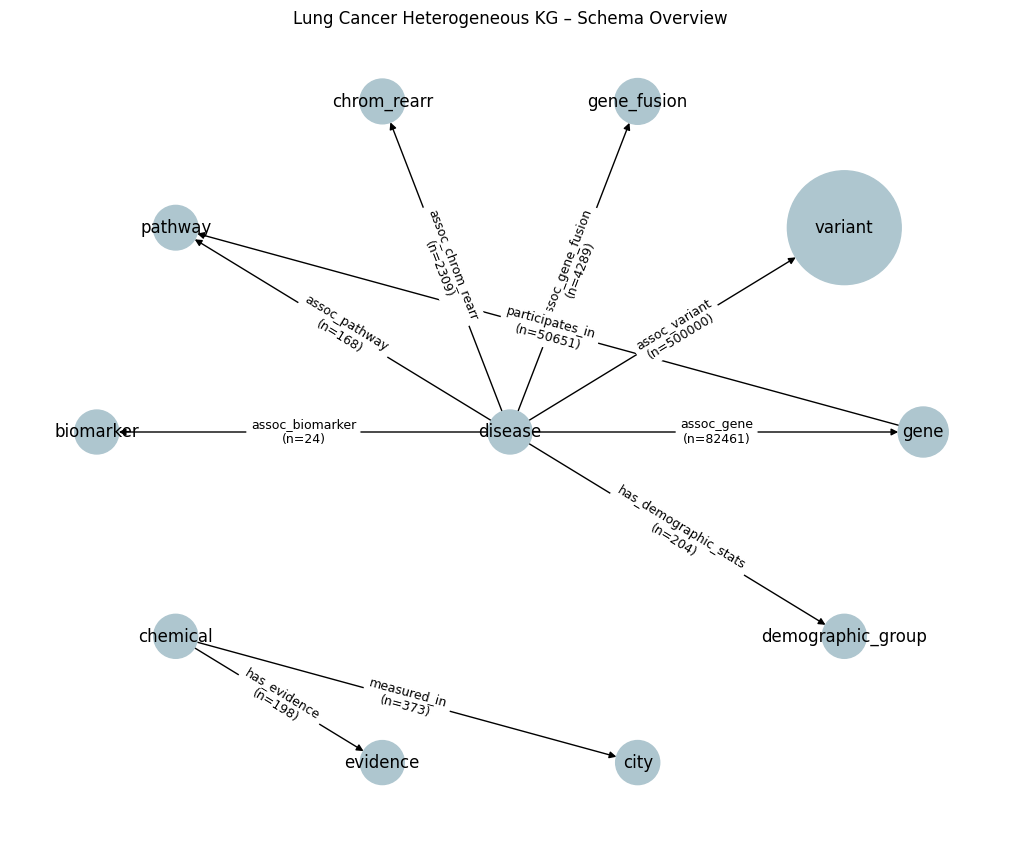

In [ ]:
G = nx.DiGraph()

# Node-Typen als Knoten
for ntype in node_stats.keys():
    G.add_node(ntype, size=node_stats[ntype])

# Relationstypen als Kanten (mit Edge-Anzahl)
G.add_edge("disease", "gene",              rel="assoc_gene",          count=edge_stats["disease_gene"])
G.add_edge("disease", "gene_fusion",       rel="assoc_gene_fusion",   count=edge_stats["disease_gene_fusion"])
G.add_edge("disease", "chrom_rearr",       rel="assoc_chrom_rearr",   count=edge_stats["disease_chrom_rearr"])
G.add_edge("disease", "variant",           rel="assoc_variant",       count=edge_stats["disease_variant"])
G.add_edge("disease", "pathway",           rel="assoc_pathway",       count=edge_stats["pathway_disease_association"])
G.add_edge("gene",    "pathway",           rel="participates_in",     count=edge_stats["disease_gene_pathway"])
G.add_edge("disease", "biomarker",         rel="assoc_biomarker",     count=edge_stats["disease_biomarker"])
G.add_edge("chemical","evidence",          rel="has_evidence",        count=edge_stats["chemical_evidence"])
G.add_edge("chemical","city",              rel="measured_in",         count=edge_stats["chemical_location"])
G.add_edge("disease", "demographic_group", rel="has_demographic_stats", count=edge_stats["disease_demographics"])

plt.figure(figsize=(10, 8))

# layout: disease in die Mitte, Rest im Kreis
center = "disease"
pos = {center: (0.0, 0.0)}
others = [n for n in G.nodes if n != center]

import math
radius = 3.0
for i, n in enumerate(others):
    angle = 2 * math.pi * i / len(others)
    pos[n] = (radius * math.cos(angle), radius * math.sin(angle))

# Node sizes
sizes = [1000 + 0.02 * G.nodes[n]["size"] for n in G.nodes]

nx.draw(G, pos, with_labels=True, node_size=sizes, node_color="#aec6cf", arrows=True)

# Edge labels: Relation + Anzahl
edge_labels = {
    (u, v): f'{d["rel"]}\n(n={d["count"]})'
    for u, v, d in G.edges(data=True)
}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)

plt.title("Lung Cancer Heterogeneous KG – Schema Overview")
plt.axis("off")
plt.show()
